# <left>#2: Measuring Trees - interactive Python notebook

## Howdy! 

This ipynb is the second step towards automating the process of measuring trees.

This notebook assumes the ipynb resides directly in the “main directory” with a ‘_input’ folder housing the input files. We will create and use an ‘output’ folder for output files.

- This notebook will take the `lidR` output tt points and cw polygons as inputs. 
- These inputs will be joined to field data points and calculate Improved Crown Width (ICW). 
- Output will be a CSV file and histograms. 

***
### 1.0 - Setup Notebook

#### Import the necessary modules 

In [1]:
import os 
import arcpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Set workspace 
Creates an "output" folder and sets it as the current working directory so all outputs below don't need a folder specified. 
This also creates other folders such as "figures". 

In [2]:
output = './output/'
if not os.path.exists(output):
    os.makedirs(output)

path = os.getcwd() + '\\output'
os.chdir(path)

arcpy.env.workspace = path
arcpy.env.overwriteOutput = True

figpath = '../figures/'
if not os.path.exists(figpath):
    os.makedirs(figpath)

print(os.getcwd())

c:\Temp\sample_code\02_lidR_tt_cw\output


### 2.0 - Load Data

If using the "_input" folder for model inputs, this cell lists the files and specific extentions in the folder. 

In [30]:
in_dir = '../_input/'

ext = '.shp'
for file in os.listdir(in_dir):
    if file.endswith(ext):
        print(ext + ' files in "_input" folder: ' + file)

ext = '.csv'
for file in os.listdir(in_dir):
    if file.endswith(ext):
        print(ext + ' files in "_input" folder: ' + file)

.shp files in "_input" folder: crowns1.shp
.shp files in "_input" folder: field_trees.shp
.shp files in "_input" folder: ttops1.shp


Specifies the inputs from "_input" folder or from absolute path. 

In [31]:
in_tt = '../_input/ttops1.shp' 
# tree top points 

in_ca = '../_input/crowns1.shp' 
# crown area polygons 

in_tree_pts = '../_input/field_trees.shp'
# field inventory 

Makes a copy of the input datasets for safety because some operations will alter the inputs. 

In [5]:
arcpy.conversion.ExportFeatures(in_tt, '../_input/ttops1_copy.shp')
arcpy.conversion.ExportFeatures(in_ca, '../_input/crowns1_copy.shp' )
arcpy.conversion.ExportFeatures(in_tree_pts, '../_input/field_trees_copy.shp')

in_tt = '../_input/ttops1_copy.shp' 
in_ca = '../_input/crowns1_copy.shp' 
in_tree_pts = '../_input/field_trees_copy.shp'

Check the sampled tree points table. 

In [26]:
arcpy.conversion.ExportTable(in_tree_pts, 'out.csv')
df0 = pd.read_csv('out.csv')
df0.head()

,X,Y,TID,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,NEAR_FID,NEAR_DIST
0,754251.089289,3.389062e+06,1,0.325,7.7,0.424,6.98,9.0,261,2.099206
1,754219.000144,3.389035e+06,2,0.274,5.7,0.360,5.41,8.1,269,2.257742
2,754182.715187,3.389006e+06,3,0.315,6.2,0.350,6.19,9.6,275,1.852275
3,754136.122764,3.388967e+06,4,0.307,7.3,0.300,7.22,8.8,288,0.337533
4,754077.939157,3.388919e+06,5,0.310,8.2,0.360,7.40,11.2,295,1.269582


Review the TT table. 

In [27]:
arcpy.conversion.ExportTable(in_tt, 'out.csv')
df1 = pd.read_csv('out.csv')
df1.head()

,treeID,Z
0,1,6.938
1,2,11.497
2,3,7.333
3,4,12.867
4,5,11.791


Review the CA table. 

In [28]:
arcpy.conversion.ExportTable(in_ca, 'out.csv')
df1 = pd.read_csv('out.csv')
df1.head()

,treeID,Z,npoints,cnvhll_
0,1.0,6.938,91,21.250
1,2.0,11.497,403,108.250
2,3.0,7.333,41,8.000
3,4.0,12.867,672,174.375
4,5.0,11.791,376,106.000


### 3.0 - Analysis

We want to correlate field measurements to algorithm measurements, so we need to tie them together. <br>
Verify that the tree top points are within a reasonable distance of the sampled tree points. 

In [9]:
arcpy.analysis.Near(in_tree_pts, in_tt)
arcpy.conversion.ExportTable(in_tree_pts, 'out.csv')
df1 = pd.read_csv('out.csv')
df1.head() 

,X,Y,TID,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,NEAR_FID,NEAR_DIST
0,754251.089289,3.389062e+06,1,0.325,7.7,0.424,6.98,9.0,261,2.099206
1,754219.000144,3.389035e+06,2,0.274,5.7,0.360,5.41,8.1,269,2.257742
2,754182.715187,3.389006e+06,3,0.315,6.2,0.350,6.19,9.6,275,1.852275
3,754136.122764,3.388967e+06,4,0.307,7.3,0.300,7.22,8.8,288,0.337533
4,754077.939157,3.388919e+06,5,0.310,8.2,0.360,7.40,11.2,295,1.269582


Use MBG to measure crown polygons length and width. Full documentation below: <br>
https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/minimum-bounding-geometry.htm

In [10]:
in_ca_mbg = 'ca_MBG.shp'
arcpy.management.MinimumBoundingGeometry(in_ca, in_ca_mbg, "CONVEX_HULL", 'NONE', 
                                         mbg_fields_option='MBG_FIELDS')
arcpy.conversion.ExportTable(in_ca_mbg, 'out.csv')
df1 = pd.read_csv('out.csv')
df1.head()

,treeID,Z,npoints,cnvhll_,ORIG_FID,MBG_Width,MBG_Length,MBG_APodX1,MBG_APodY1,MBG_APodX2,MBG_APodY2,MBG_Orient
0,1.0,6.938,91,21.250,0,3.795,7.762,754895.458,3390000.0,754902.958,3390000.0,0.0
1,2.0,11.497,403,108.250,1,8.950,16.155,754905.958,3390000.0,754911.958,3390000.0,0.0
2,3.0,7.333,41,8.000,2,2.372,5.148,754845.958,3390000.0,754848.458,3390000.0,0.0
3,4.0,12.867,672,174.375,3,13.115,19.007,754862.958,3390000.0,754879.958,3390000.0,0.0
4,5.0,11.791,376,106.000,4,10.910,13.038,754887.958,3390000.0,754894.958,3390000.0,0.0


Join tree points with TT using FID. 

In [11]:
join_tt = "treept_join_tt"

join1 = arcpy.management.AddJoin(in_tree_pts, 'NEAR_FID', in_tt, 'FID')
joinresult = arcpy.conversion.ExportFeatures(join1, join_tt)

joinresultFields = arcpy.ListFields(joinresult)

# Print all fields. 
print([field.name for field in joinresultFields])
# Show field details. 
for field in joinresultFields:
    print(f"{field.name} has a type of {field.type} with a length of {field.length}")

['FID', 'Shape', 'X', 'Y', 'TID', 'dbh_m_f', 'h_m_f', 'dbh_m_mls', 'h_m_mls', 'cw_m_mls', 'NEAR_FID', 'NEAR_DIST', 'FID_', 'treeID', 'Z']
FID has a type of OID with a length of 4
Shape has a type of Geometry with a length of 0
X has a type of Double with a length of 19
Y has a type of Double with a length of 19
TID has a type of Integer with a length of 10
dbh_m_f has a type of Double with a length of 19
h_m_f has a type of Double with a length of 19
dbh_m_mls has a type of Double with a length of 19
h_m_mls has a type of Double with a length of 19
cw_m_mls has a type of Double with a length of 19
NEAR_FID has a type of Integer with a length of 10
NEAR_DIST has a type of Double with a length of 19
FID_ has a type of Integer with a length of 9
treeID has a type of Integer with a length of 9
Z has a type of Double with a length of 19


Join tree points with CA MBG using treeID (FID is not the same between TT and CA). 

In [12]:
join_ca = "treept_join_ca"

join1 = arcpy.management.AddJoin(join_tt, 'treeID', in_ca_mbg, 'treeID')
joinresult = arcpy.conversion.ExportFeatures(join1, join_ca)

joinresultFields = arcpy.ListFields(joinresult)

# Print all fields. 
print([field.name for field in joinresultFields])
# Show field details. 
for field in joinresultFields:
    print(f"{field.name} has a type of {field.type} with a length of {field.length}")

['FID', 'Shape', 'X', 'Y', 'TID', 'dbh_m_f', 'h_m_f', 'dbh_m_mls', 'h_m_mls', 'cw_m_mls', 'NEAR_FID', 'NEAR_DIST', 'FID_', 'treeID', 'Z', 'FID1', 'treeID_1', 'Z_1', 'npoints', 'cnvhll_', 'ORIG_FID', 'MBG_Width', 'MBG_Length', 'MBG_APodX1', 'MBG_APodY1', 'MBG_APodX2', 'MBG_APodY2', 'MBG_Orient']
FID has a type of OID with a length of 4
Shape has a type of Geometry with a length of 0
X has a type of Double with a length of 19
Y has a type of Double with a length of 19
TID has a type of Integer with a length of 10
dbh_m_f has a type of Double with a length of 19
h_m_f has a type of Double with a length of 19
dbh_m_mls has a type of Double with a length of 19
h_m_mls has a type of Double with a length of 19
cw_m_mls has a type of Double with a length of 19
NEAR_FID has a type of Integer with a length of 10
NEAR_DIST has a type of Double with a length of 19
FID_ has a type of Integer with a length of 9
treeID has a type of Integer with a length of 9
Z has a type of Double with a length of 1

Review the table: tree points + TT + CA 

In [13]:
arcpy.conversion.ExportTable(join_ca, 'out.csv')
df1 = pd.read_csv('out.csv')
df1.head()

,X,Y,TID,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,NEAR_FID,NEAR_DIST,...,npoints,cnvhll_,ORIG_FID,MBG_Width,MBG_Length,MBG_APodX1,MBG_APodY1,MBG_APodX2,MBG_APodY2,MBG_Orient
0,754251.089289,3.389062e+06,1,0.325,7.7,0.424,6.98,9.0,261,2.099206,...,252,61.250,260,8.321,9.657,754247.958,3390000.0,754256.958,3390000.0,0.0
1,754219.000144,3.389035e+06,2,0.274,5.7,0.360,5.41,8.1,269,2.257742,...,170,43.250,268,7.071,8.515,754217.958,3390000.0,754218.458,3390000.0,0.0
2,754182.715187,3.389006e+06,3,0.315,6.2,0.350,6.19,9.6,275,1.852275,...,219,58.250,274,7.647,9.823,754177.458,3390000.0,754186.958,3390000.0,0.0
3,754136.122764,3.388967e+06,4,0.307,7.3,0.300,7.22,8.8,288,0.337533,...,234,59.875,287,8.222,9.823,754134.458,3390000.0,754136.958,3390000.0,0.0
4,754077.939157,3.388919e+06,5,0.310,8.2,0.360,7.40,11.2,295,1.269582,...,333,81.000,294,9.241,11.180,754075.958,3390000.0,754077.958,3390000.0,0.0


Create dataframe subset of the important fields. 

In [14]:
df_sub = df1[['X', 'Y', 'dbh_m_f', 'h_m_f', 'dbh_m_mls', 'h_m_mls', 'cw_m_mls', 
              'NEAR_FID', 'FID_', 'treeID', 'Z', 'FID1', 'treeID_1', 'Z_1', 
              'cnvhll_', 'MBG_Width', 'MBG_Length']]
df_sub.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,NEAR_FID,FID_,treeID,Z,FID1,treeID_1,Z_1,cnvhll_,MBG_Width,MBG_Length
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,261,261,262,7.522,260,262.0,7.522,61.250,8.321,9.657
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,269,269,270,5.528,268,270.0,5.528,43.250,7.071,8.515
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,275,275,276,6.588,274,276.0,6.588,58.250,7.647,9.823
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,288,288,289,7.626,287,289.0,7.626,59.875,8.222,9.823
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,295,295,296,7.747,294,296.0,7.747,81.000,9.241,11.180


Verifty that: 
 - NEAR_FID == FID_ 
 - treeID == treeID_1 

This is just to make sure everybody is correctly aligned. 

In [15]:
df_tf1 = df1['NEAR_FID'] == df1['FID_']
df_tf2 = df1['treeID'] == df1['treeID_1']

print('FID check:    ' + str(df_tf1.all()))
print('treeID check: ' + str(df_tf2.all()))

FID check:    True
treeID check: True


Remove the rest of the unnecessary fields. 

In [16]:
df_sub2 = df_sub[['X', 'Y', 'dbh_m_f', 'h_m_f', 'dbh_m_mls', 'h_m_mls', 'cw_m_mls', 
                  'Z', 'cnvhll_', 'MBG_Width', 'MBG_Length', 'treeID']]
df_sub2.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,Z,cnvhll_,MBG_Width,MBG_Length,treeID
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296


***
Copy DF for safety. 
***

In [17]:
df4 = df_sub2.copy()
df4.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,Z,cnvhll_,MBG_Width,MBG_Length,treeID
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296


Rename columns. 

In [18]:
df5 = df4.rename(columns={'Z': 'h_m_tt', 'cnvhll_': 'ca_m2'}) 
df5.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,MBG_Length,treeID
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296


Calculate cw_avg <br>(average of MBG length and width). 

In [19]:
df5['cw_avg'] = df5[["MBG_Length", "MBG_Width"]].mean(axis=1)
df5.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,MBG_Length,treeID,cw_avg
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262,8.9890
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270,7.7930
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276,8.7350
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289,9.0225
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296,10.2105


Calculate cw_pi <br>(d = 2(sqrt(a/pi))) <br>
This assumes that the crowns are perfect circles, but that's why we will take an average for the ICW. 

In [20]:
df5['cw_pi'] = np.sqrt(df5['ca_m2'].div(math.pi)).mul(2)
df5.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,MBG_Length,treeID,cw_avg,cw_pi
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262,8.9890,8.830964
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270,7.7930,7.420755
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276,8.7350,8.611980
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289,9.0225,8.731278
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296,10.2105,10.155413


Calculate Improved Crown Width (ICW) <br> (average of cw_avg and cw_pi)

In [21]:
df5['icw'] = df5[["cw_avg", "cw_pi"]].mean(axis=1)
df5.head()

,X,Y,dbh_m_f,h_m_f,dbh_m_mls,h_m_mls,cw_m_mls,h_m_tt,ca_m2,MBG_Width,MBG_Length,treeID,cw_avg,cw_pi,icw
0,754251.089289,3.389062e+06,0.325,7.7,0.424,6.98,9.0,7.522,61.250,8.321,9.657,262,8.9890,8.830964,8.909982
1,754219.000144,3.389035e+06,0.274,5.7,0.360,5.41,8.1,5.528,43.250,7.071,8.515,270,7.7930,7.420755,7.606878
2,754182.715187,3.389006e+06,0.315,6.2,0.350,6.19,9.6,6.588,58.250,7.647,9.823,276,8.7350,8.611980,8.673490
3,754136.122764,3.388967e+06,0.307,7.3,0.300,7.22,8.8,7.626,59.875,8.222,9.823,289,9.0225,8.731278,8.876889
4,754077.939157,3.388919e+06,0.310,8.2,0.360,7.40,11.2,7.747,81.000,9.241,11.180,296,10.2105,10.155413,10.182956


Export dataframe to csv for outside analysis.

In [22]:
df5.to_csv('field_tt_cw_out.csv', index=False)

### 4.0 - Plots

#### Histogram of field heights. 

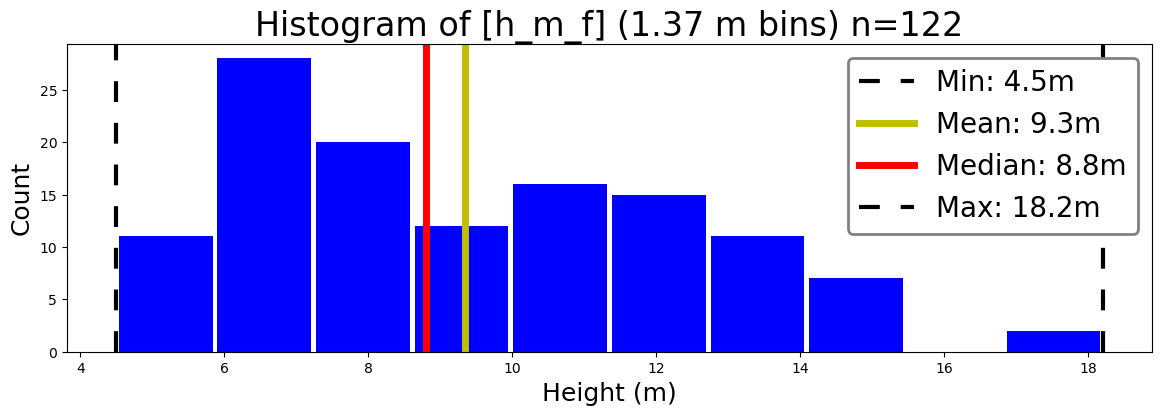

In [23]:
parameter = 'h_m_f'
values = df5[parameter]
bin_no = 10

bin_width = round((np.ptp(values) / bin_no), 2) 
title = 'Histogram of [' + parameter + '] (' + str(bin_width) + ' m bins) n=' + 
str(len(values))

val_mean = np.mean(values)
val_med = np.median(values)
val_min = np.min(values)
val_max = np.max(values)

bins = np.linspace(values.min(), values.max(),(bin_no + 1))

plt.subplots(figsize=(14,4))
plt.axvline(val_min, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Min: ' + 
            str(round(val_min, 1)) + 'm')
plt.axvline(val_mean, color = 'y', linewidth = 5, label = 'Mean: ' + 
            str(round(val_mean, 1)) + 'm')
plt.axvline(val_med, color = 'r', linewidth = 5, label = 'Median: ' + 
            str(round(val_med, 1)) + 'm')
plt.axvline(val_max, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Max: ' + 
            str(round(val_max, 1)) + 'm')
plt.hist(values, bins = bins, color = 'b', rwidth=.95)
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_alpha(None)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title +'.png', bbox_inches='tight')
plt.show()

#### Histogram of `lidR` code heights. 

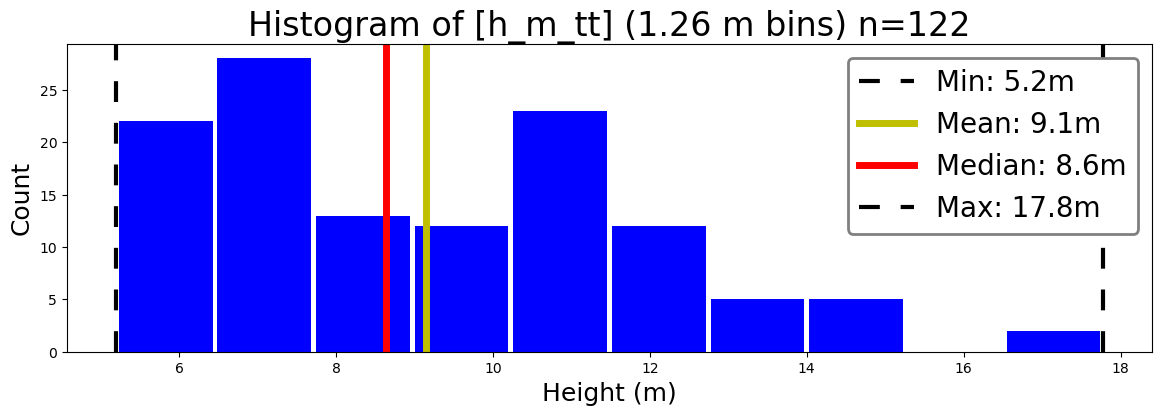

In [24]:
parameter = 'h_m_tt'
values = df5[parameter]
bin_no = 10

bin_width = round((np.ptp(values) / bin_no), 2) 
title = 'Histogram of [' + parameter + '] (' + str(bin_width) + ' m bins) n=' + 
str(len(values))

val_mean = np.mean(values)
val_med = np.median(values)
val_min = np.min(values)
val_max = np.max(values)

bins = np.linspace(values.min(), values.max(),(bin_no + 1))

plt.subplots(figsize=(14,4))
plt.axvline(val_min, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Min: ' + 
            str(round(val_min, 1)) + 'm')
plt.axvline(val_mean, color = 'y', linewidth = 5, label = 'Mean: ' + 
            str(round(val_mean, 1)) + 'm')
plt.axvline(val_med, color = 'r', linewidth = 5, label = 'Median: ' + 
            str(round(val_med, 1)) + 'm')
plt.axvline(val_max, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Max: ' + 
            str(round(val_max, 1)) + 'm')
plt.hist(values, bins = bins, color = 'b', rwidth=.95)
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_alpha(None)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title +'.png', bbox_inches='tight')
plt.show()

#### Histogram of improved crown widths (ICW). 

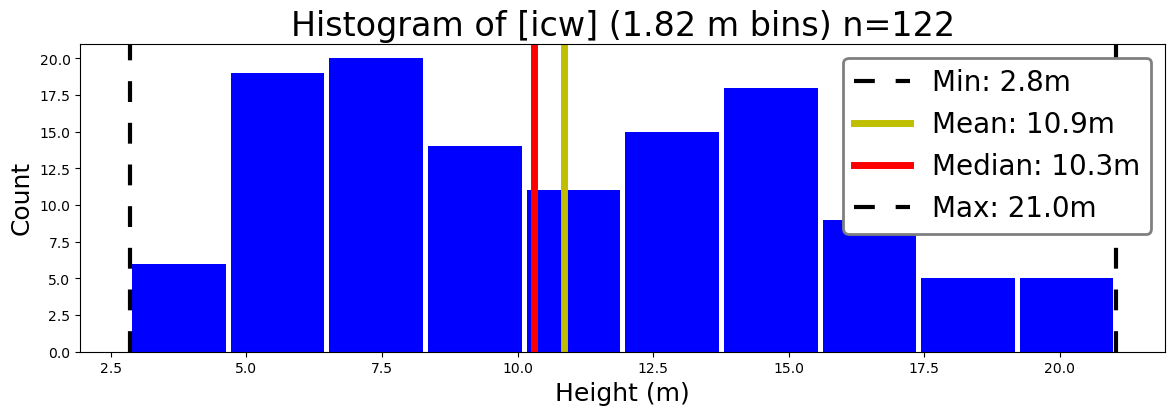

In [25]:
parameter = 'icw'
values = df5[parameter]
bin_no = 10

bin_width = round((np.ptp(values) / bin_no), 2) 
title = 'Histogram of [' + parameter + '] (' + str(bin_width) + ' m bins) n=' + 
str(len(values))

val_mean = np.mean(values)
val_med = np.median(values)
val_min = np.min(values)
val_max = np.max(values)

bins = np.linspace(values.min(), values.max(),(bin_no + 1))

plt.subplots(figsize=(14,4))
plt.axvline(val_min, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Min: ' + 
            str(round(val_min, 1)) + 'm')
plt.axvline(val_mean, color = 'y', linewidth = 5, label = 'Mean: ' + 
            str(round(val_mean, 1)) + 'm')
plt.axvline(val_med, color = 'r', linewidth = 5, label = 'Median: ' + 
            str(round(val_med, 1)) + 'm')
plt.axvline(val_max, color = 'k', linewidth = 3, ls=(0,(5,5)), label = 'Max: ' + 
            str(round(val_max, 1)) + 'm')
plt.hist(values, bins = bins, color = 'b', rwidth=.95)
plt.title(title, size = 24)
plt.xlabel('Height (m)', size = 18)
plt.ylabel('Count', size = 18)
leg = plt.legend(loc = 'upper right', fontsize = '20')
leg.get_frame().set_alpha(None)
leg.get_frame().set_edgecolor('gray')
leg.get_frame().set_linewidth(2)
plt.savefig(figpath + title +'.png', bbox_inches='tight')
plt.show()

These results can now be used as is or fed into the next analysis workbook.

## Contact 

**Justinn J. Jones ’24, GISP**

Graduate Research Assistant / FAA sUAS RP

LASERS Lab / WFES 360

Department of Ecology & Conservation Biology

College of Agriculture & Life Sciences

justinn.j.jones@tamu.edu

**TEXAS A&M UNIVERSITY**